# Finite Span Wing
This notebook will use the vortex lattice method theory to predict of a finite span wing.

The user must provide:
 - The wingspan (b)
 - The chord length as a function of position along the wing (c(y))
 - The geometric angle of attack (alpha)
 - The zero-lift angle of attack of the airfoil section being used (alpha_0)
 - The number of modes to use in the panel solver (N)
 
The outputs of this program include
 - Plots of the circulation distribution, lift coefficient, moment coefficient at the quarter chord, and center of pressure saved in the plots folder.
 - Table of the above values saved in the data folder.
 
Once those are provided you simply need to run all the cells in the notebook to generate the output. A NACA 0012 demonstration case is included by default.

Import some useful libraries

In [1]:
from sympy import *
import math
import numpy as np
import matplotlib.pyplot as plt

# Define the symbolic variables
y = symbols('y')

Definte a function for the finite wing solver

In [2]:
def finite_wing(b, c, alpha_0, alpha, N, plotflag):
    # Define the symbolic variables
    y, theta = symbols('y theta')

    # Force things to be symbolic
    c = c + 0 * y
    alpha_0 = alpha_0 + 0 * y

    # Convert the zero-lift angle of attack to radians
    alpha_0 = alpha_0 * math.pi / 180

    # Convert the geometric angle of attack to radians
    alpha = alpha * math.pi / 180

    # Get the wing area (m^2)
    S = integrate(c, (y, -b / 2, b / 2))

    # Get the aspect ratio
    AR = b ** 2 / S

    # Get the taper ratio
    TR = c.subs(y, b / 2) / c.subs(y, 0)

    # Print the aspect and taper ratios
    print('Aspect Ratio: ', AR)
    print('Taper Ratio:', TR)
    print('Wing Area: ', S)

    # Convert everything to theta coordinates
    cy = c
    c = c.subs(y, - b / 2 * cos(theta))
    alpha_0 = alpha_0.subs(y, - b / 2 * cos(theta))

    # Allocate memory for the linear system
    A = np.zeros((N, N))
    beta = np.zeros(N)

    # Generate the entries in the linear system
    for i in range(0, N):
        # Get the theta_0 position of this point
        theta_0 = math.pi * (i + 0.5) / N
        beta[i] = (alpha - alpha_0).subs(theta, theta_0)

        # Generate the coefficient matrix
        for j in range(0, N):
            # First term
            A[i, j] = 2 * b / (math.pi * c.subs(theta, theta_0)) * sin((j + 1) * theta_0)

            # Second term
            A[i, j] += (j + 1) * sin((j + 1) * theta_0) / sin(theta_0)

    # Solve the linear system for the An coefficients
    An = np.linalg.solve(A, beta)

    # Get the lift coefficient
    Cl = An[0] * math.pi * b ** 2 / S

    # Get the delta coefficient for the drag coefficient
    delta = 0
    for i in range(1, N):
        delta += (i + 1) * (An[i] / An[0]) ** 2

    # Compute the induced drag coefficient
    Cdi = Cl ** 2 / (math.pi * AR) * (1 + delta)

    # Get the span efficiency factor
    eps = 1 / (1 + delta)

    print('Lift Coefficient: ', Cl)
    print('Drag Coefficient: ', Cdi)
    print('Induced Drag Factor: ', delta)
    print('Oswald Efficiency Factor: ', eps)

    # Compute the circulation distribution
    gamma = 0
    for i in range(0, N):
        gamma += 2 * b * An[i] * sin((i + 1) * theta)

    gamma = gamma.subs(theta, acos(y * - 2 / b))

    # Plot the circulation distribution
    if (plotflag):
        nplot = 200
        clplot = np.zeros(nplot)
        yplot = np.zeros(nplot)
        cplot = np.zeros(nplot)
        for i in range(0, nplot):
            yplot[i] = i * b / (nplot - 1) - b / 2
            clplot[i] = 2 * gamma.subs(y, yplot[i]) / (S / b)
            cplot[i] = cy.subs(y, yplot[i])

        # Create the subplot framework
        fig, plot = plt.subplots(2, 1)

        plot[0].plot(yplot, clplot)
        plot[0].set_xlabel('$y$')
        plot[0].set_ylabel('$C_L c / c_{ref}$')
        np.savetxt('data/clcovercref.txt', np.column_stack((yplot, clplot)), delimiter=' ')

        # Plot and save the chord length distribution
        cplot = np.concatenate(([0], cplot, [0], [0]))
        yplot = np.concatenate(([-b / 2], yplot, [b / 2], [-b / 2]))

        plot[1].plot(yplot, cplot)
        plot[1].set_xlabel('$y$')
        plot[1].set_ylabel('$c$')
        np.savetxt('data/wing.txt', np.column_stack((yplot, cplot)), delimiter=' ')

        # Save the plots and data
        plt.show()
        fig.savefig('plots/clcovercref.pdf')

    return Cl, Cdi

Define a function to plot the drag polar

In [3]:
def drag_polar(b, c, alpha_0, N):
    # Specify the number of angles to get Cl and Cdi at
    Npoints = 20

    # Create arrays to store Cl and Cdi for plotting
    Clplot = np.zeros(Npoints)
    Cdiplot = np.zeros(Npoints)
    alphaplot = np.zeros(Npoints)

    for i in range(0, Npoints):
        # Get the geometric angle of attack
        alpha = i / (Npoints - 1) * 15 - 5

        # Get the lift and induced drag coefficients
        [Cl, Cdi] = finite_wing(b, c, alpha_0, alpha, N, false)

        # Store them in their respective arrays
        alphaplot[i] = alpha
        Clplot[i] = Cl
        Cdiplot[i] = Cdi

    # Generate the plots
    fig, plot = plt.subplots()
    plot.plot(alphaplot, Clplot, label='$C_L$')
    plot.plot(alphaplot, 2 * math.pi * ((alphaplot - alpha_0) / 180 * math.pi), '--', label='Thin Airfoil Theory')
    plot.set_title('Lift Coefficient')
    plot.set_xlabel('α')
    plot.set_ylabel('$C_{L}$')
    plot.legend()
    plt.grid()
    plt.show()
    fig.savefig('plots/lift_coefficient.pdf')

    fig, plot = plt.subplots()
    plot.plot(alphaplot, Cdiplot)
    plot.set_title('Drag Coefficient')
    plot.set_xlabel('α')
    plot.set_ylabel('$C_{D,i}$')
    plt.grid()
    plt.show()
    fig.savefig('plots/drag_coefficient.pdf')

    fig, plot = plt.subplots()
    plot.plot(Cdiplot, Clplot)
    plot.set_title('Drag Polar')
    plot.set_xlabel('$C_{D,i}$')
    plot.set_ylabel('$C_{L}$')
    plt.grid()
    plt.show()
    fig.savefig('plots/drag_polar.pdf')

    # Save the data to txt files
    np.savetxt('data/liftdrag.txt', np.column_stack((alphaplot, Clplot, Cdiplot)), delimiter=' ')

    return

Provide the definition of the wing shape and run the solver

Aspect Ratio:  3.69230769230769
Taper Ratio: 0.625000000000000
Wing Area:  2.43750000000000
Lift Coefficient:  0.209616456181324
Drag Coefficient:  0.00382326626050480
Induced Drag Factor:  0.009326214838478343
Oswald Efficiency Factor:  0.9907599597618985


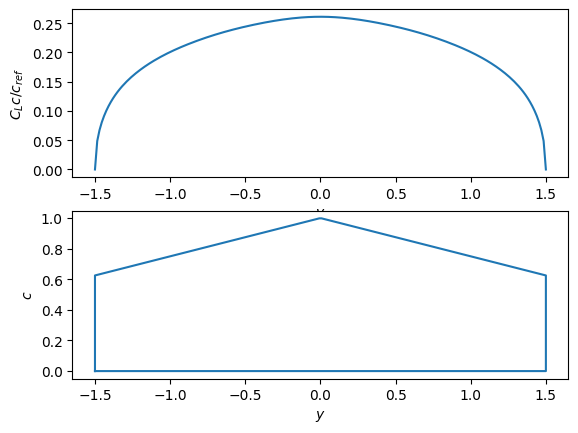

Aspect Ratio:  3.69230769230769
Taper Ratio: 0.625000000000000
Wing Area:  2.43750000000000
Lift Coefficient:  -0.209616456181324
Drag Coefficient:  0.00382326626050480
Induced Drag Factor:  0.009326214838478343
Oswald Efficiency Factor:  0.9907599597618985
Aspect Ratio:  3.69230769230769
Taper Ratio: 0.625000000000000
Wing Area:  2.43750000000000
Lift Coefficient:  -0.154454230870449
Drag Coefficient:  0.00207578999185302
Induced Drag Factor:  0.00932621483847835
Oswald Efficiency Factor:  0.9907599597618985
Aspect Ratio:  3.69230769230769
Taper Ratio: 0.625000000000000
Wing Area:  2.43750000000000
Lift Coefficient:  -0.0992920055595745
Drag Coefficient:  0.000857851986429055
Induced Drag Factor:  0.009326214838478347
Oswald Efficiency Factor:  0.9907599597618985
Aspect Ratio:  3.69230769230769
Taper Ratio: 0.625000000000000
Wing Area:  2.43750000000000
Lift Coefficient:  -0.0441297802486998
Drag Coefficient:  0.000169452244232900
Induced Drag Factor:  0.009326214838478349
Oswald Effi

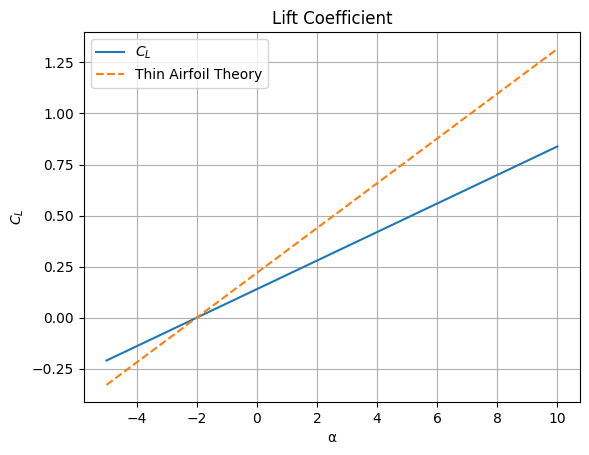

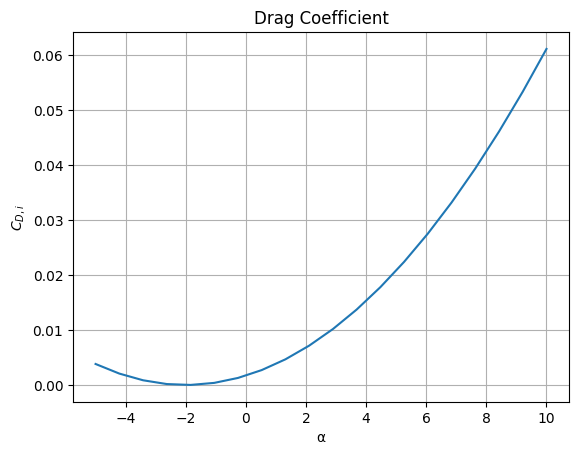

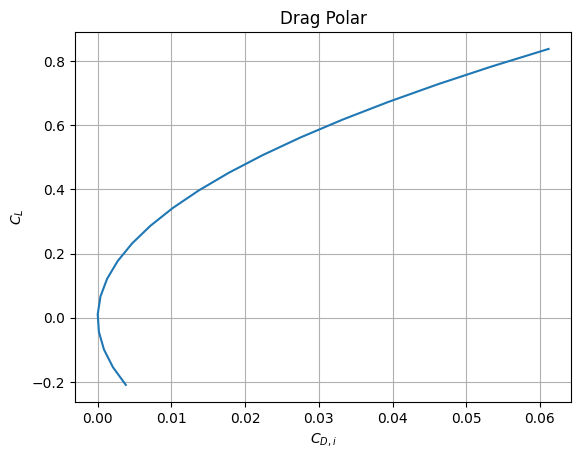

In [4]:
# Define the input parameters
b = 3  # Wingspan (m)
c = 1 - abs(y) / 4  # Chord length as a function of spanwise location (m)
alpha = 1  # Geometric angle of attack of the wing (deg)
alpha_0 = -2  # Zero-lift angle of attack as a function of spanwise location (deg)
N = 20  # Number of terms in the expansion

# Call the main function
finite_wing(b, c, alpha_0, alpha, N, true)

# Call the drag polar plotter
drag_polar(b, c, alpha_0, N)